In [1]:
from scipy.io.idl import readsav
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
import cython_modules.interp as cinterp
from astropy.io import fits
%matplotlib inline

In [2]:
def make_lanes(vx, vy, nsteps=40, maxstep=4):

    dims = vx.shape

    # Gamma scale the velocity
    vmag = np.sqrt(vx**2 + vy**2)
    vmax = vmag.max()
    vn = vmag/vmax
    gamma = 0.5
    g = vn**(gamma-1)
    vxn = vx/vmax
    vyn = vy/vmax
    vxng = vxn*g
    vyng = vyn*g
    # Padding
    vblank = np.zeros([dims[0]+2*maxstep, dims[1]+2*maxstep], dtype=np.float32)
    vx2 = vblank.copy()
    vy2 = vblank.copy()
    vx2[maxstep : dims[0] + maxstep, maxstep :dims[1] + maxstep] = vxng.astype(np.float32)
    vy2[maxstep : dims[0] + maxstep, maxstep :dims[1] + maxstep] = vyng.astype(np.float32)
    # Invert velocity
    vx2 *= -1
    vy2 *= -1
    # Define the grid of coordinates
    x0, y0 = np.meshgrid( maxstep + np.arange(dims[1]) , maxstep + np.arange(dims[0]))
    xold = x0.flatten().astype(np.float32)
    yold = y0.flatten().astype(np.float32)
    # Scaling factor for the RK4 integration
    maxv = np.sqrt(vx2.max() ** 2 + vy2.max() ** 2)
    # Begin RK4 integration
    for n in range(nsteps):

        dx1 = maxstep * cinterp.cbilin_interp1(vx2, xold, yold)/maxv
        dy1 = maxstep * cinterp.cbilin_interp1(vy2, xold, yold)/maxv

        dx2 = maxstep * cinterp.cbilin_interp1(vx2, xold+dx1, yold+dy1) / maxv
        dy2 = maxstep * cinterp.cbilin_interp1(vy2, xold+dx1, yold+dy1) / maxv

        x = xold + (dx1 + dx2)/2
        y = yold + (dy1 + dy2)/2

        xold = x
        yold = y

    xforwards = xold.reshape(dims)
    yforwards = yold.reshape(dims)
    # Take into account the padding
    xforwards -= maxstep
    yforwards -= maxstep
    # Clip the positions in case they overshoot due to maxstep
    np.clip(xforwards, 0, dims[1]-1, out=xforwards)
    np.clip(yforwards, 0, dims[0]-1, out=yforwards)
    # Take the delta of the displacements in both directions
    gxx = np.gradient(xforwards, axis=1)
    gyy = np.gradient(yforwards, axis=0)
    # map it as a distance
    lanes = np.sqrt(gxx**2 + gyy**2)

    return lanes

In [4]:
# read IDL save file. update path to personal case
idlsav = readsav('/mnt/data2/Karin/20160607_231411-EEMAP5-hmi-mag-lct-vxvy-1haverage.save')
# Get vx and vy
vx = idlsav['hmilctvxav1']['data'][0]
vy = idlsav['hmilctvyav1']['data'][0]

((548, 400), (548, 400))

In [5]:
lanes1 = make_lanes(vx, vy)

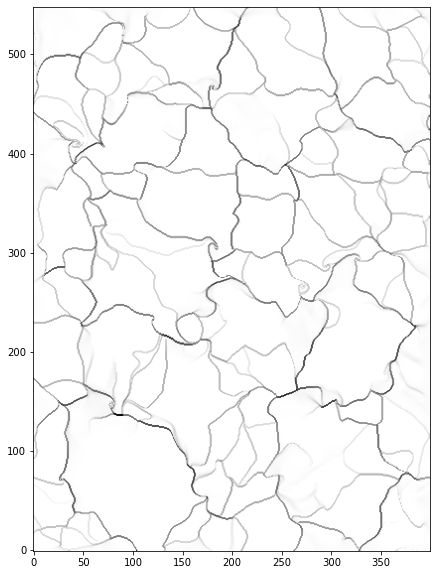

In [6]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(lanes1, origin='lower', cmap='gray_r')

In [10]:
# output to fits file 
fname = './lanes.fits'
fits.writeto(fname, lanes1, overwrite=True)